In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
np.random.seed(123456)

import sys; sys.path.append("..")
from epimodel import EpidemiologicalParameters
from epimodel.pymc3_models.mask_models import RandomWalkMobilityModel, MandateMobilityModel
from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.region_plot as rp
import epimodel.viz.prior_posterior as pp
import epimodel.viz.yougov as yg
import epimodel.viz.pred_cases as pc
import epimodel.viz.result_plot as rep
import epimodel.viz.mandate_wearing as mw
import epimodel.viz.empirical_wearing as ew

import calendar 
import theano.tensor as T
import theano.tensor.signal.conv as C
import theano

import pymc3 as pm
import pandas as pd
import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
from pathlib import Path
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set(style="ticks", font='DejaVu Serif')

import json
import matplotlib.gridspec as gridspec

Set Theano Environmental Variables for Parallelisation


In [2]:
MODEL = "cases" #args.model
MASKS = "wearing" #args.masks
W_PAR = "exp" #args.w_par

n_mandates = 2

MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
# MASKING = True # Always true

if MODEL == "both":
    TUNING = 2500
else:
    TUNING = 2000

Ds = pd.date_range("2020-05-01", "2020-09-21", freq="D")

In [3]:
# prep data object

path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
masks_object = Preprocess_masks(path=path)

masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, n_mandates = 2)
masks_object.make_preprocessed_object()
data = masks_object.data

['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs


In [4]:
# just mobility
path = "../data/modelling_set/master_data_mob_include_us_True_m_w.csv"
mobility_data = pd.read_csv(path)
mobility_data = mobility_data.set_index(["country", "date"])



In [5]:
with open("../outputs/wearing_reduction_samples.txt", "r") as f :
    wred = f.read()
    wred = np.array(wred.split("\n")[:-1]).astype(np.float64)

with open("../outputs/mandate_reduction_samples.txt", "r") as f :
    mred = f.read()
    mred = np.array(mred.split("\n")[:-1]).astype(np.float64)
    
    
with open("../outputs/wearing_alpha_samples.txt", "r") as f :
    alpha = f.read()
    alpha = np.array(alpha.split("\n")[:-1]).astype(np.float64)
    
with open('../outputs/validation_dicts.json') as f:
    sa_dict_list = json.load(f)

In [6]:
def main_result_posteriors(mred, wred, ax, both_runs=False):
    if both_runs:
        sns.kdeplot(wred, shade=True, ax=ax, label="wearing")
        sns.kdeplot(mred, label="mandate", color="green", shade=True, ax=ax)
    else:
        sns.kdeplot(wred, shade=True, ax=ax)
        
    ax.axvline(x=0, linestyle="-", color="black", alpha=0.2)
    ax.set_xlabel("% $R$ reduction\n(entire population masked)", fontsize=7)
    ax.set_xlim(-20, 60)
    
    #ax.legend()
    #ax.tick_params(axis='both', which='both', labelsize=10)
    
    ax.tick_params(
    axis='y',         
    which='both',
    #length=0
    left=False
    )
    ax.yaxis.set_ticks([]) 
    
    if both_runs:
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels, fontsize=7, frameon=False)
    
    ax.set_ylabel("Posterior density", fontsize=7)
    ax.tick_params(axis='both', which='both', labelsize=8)


def exp_reduction(a, x):
    reductions = 1 - np.exp((-1.0) * a * x)
    return reductions.mean()


def get_median_reduction(a, df):
    obs_ = []
    r = exp_reduction

    for c in df.reset_index().country.unique():
        cdf = df.loc[c]
        median_ = cdf.percent_mc.median()
        med_reduction_r = r(a, median_)
        actual = med_reduction_r
        obs_.append(actual * 100)

    return obs_
    
def plot_median_wearing_effect(df, alpha, ax):
    obs_ = get_median_reduction(alpha, df)
    print(np.percentile(obs_, [2.5, 50, 97.5]))
    sns.distplot(obs_, kde=False, hist=True, kde_kws={"shade": True}, ax=ax)

    ax.set_xlabel("% $R$ reduction (by regional wearing level)", fontsize=7)
    ax.set_ylabel("# of regions", fontsize=7)
    ax.yaxis.set_ticks([])
    ax.set_xlim(0, 25)

    med = np.median(obs_)
    print(med)
    ax.axvline(x=med, color="black", linestyle="--", label="median")

    ax.legend(fontsize=7, frameon=False, loc="upper left")
    ax.tick_params(axis='both', which='both', labelsize=8)
    

In [15]:
len([d for d in sa_dict_list if d["npi"] == "Mask Wearing"])
#len(sa_dict_list)

59

ValueError: Could not interpret input 'medians'

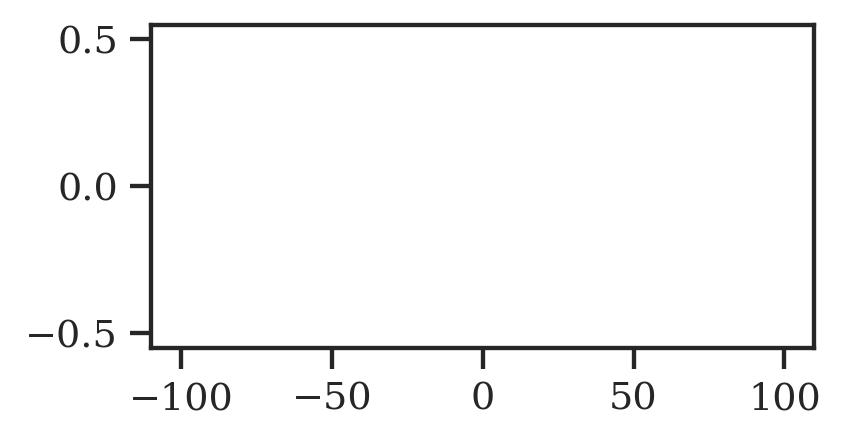

In [10]:
df = mobility_data
PNAS_WIDTH_INCHES = 3.4252
fig = plt.figure(figsize=(PNAS_WIDTH_INCHES,PNAS_WIDTH_INCHES *0.5), dpi=250)
ax = plt.gca()
sns.color_palette('colorblind')
cols = sns.color_palette('colorblind')


mandate_dict = {
    'Mask Mandates': {
        'npis': ['Mask Mandates'],
        'type': 'include',
        'color': 'grey',
        'main': True,
    }
}


dict_list = [d for d in sa_dict_list if d["npi"] == "Mask Mandates"]
medians = pd.DataFrame(dict_list)
exp_tags = np.unique(medians["tag"])
cols = [*sns.color_palette('colorblind'), *sns.color_palette('bright')]

npi_names = list(mandate_dict.keys())
npi_cols = [d['color'] for k, d in mandate_dict.items()] #maybe this should be something else

for i, col in enumerate(npi_cols):
    if i % 2 == 0:
        plt.fill_between(
            [-100, 100],
            [i-0.5, i-0.5],
            [i+0.5, i+0.5],
            color=col,
            alpha=0,
            linewidth=0,
            zorder=-5
        )
    else:
         plt.fill_between(
            [-100, 100],
            [i-0.5, i-0.5],
            [i+0.5, i+0.5],
            color=col,
            alpha=0.1,
            linewidth=0,
            zorder=-5
        )

sns.stripplot(x="med", y="medians", data=medians, size=5, zorder=1,
          jitter=0.1, order=npi_names, alpha=0.3, hue="tag", dodge=True,
          palette="colorblind", linewidth=0.05)



plt.yticks(fontsize=8, linespacing=0.8)
plt.xticks(fontsize=8)

plt.xlabel("Median reductions in $R$ (%)", fontsize=8)
plt.ylabel("")
plt.xlim([-30, 10])
plt.grid(axis='x', linewidth=0.5, zorder=-10, color="tab:gray", alpha=0.45)
#plt.xticks([0, 10, 20, 30, 40])
#plt.yticks(rotation=90)
#plt.setp( ax3.yaxis.get_majorticklabels(), va="center", ha="right" )
ax.set_yticklabels([""])

plt.legend(loc='center left', fontsize=6, ncol=1, frameon=False, fancybox=True, shadow=False)#, handletextpad=0.05)
plt.title("D", loc='left', fontweight="bold")

plt.tick_params(
    axis='y',         
    which='both',
    #length=0
    left=False
)


plt.savefig("../outputs/mandate_sa.pdf", bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(PNAS_WIDTH_INCHES *0.8,PNAS_WIDTH_INCHES* 0.5), dpi=250)
ax = plt.gca()
main_result_posteriors(mred, wred, ax=ax, both_runs=True)

plt.savefig("../outputs/mandate_posterior.pdf", bbox_inches="tight")
plt.show()

## Mandate - wearing - transmission

In [ ]:
x = 0.086


lo = np.percentile(alpha, 2.5)
hi = np.percentile(alpha, 97.5)

1 - np.exp((-1.0) * lo * x), 1 - np.exp((-1.0) * hi * x)